In [1]:
!pip install pybioclip
!git clone https://github.com/microsoft/Cream.git
!cd Cream/TinyViT && pip install -r requirements.txt
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
Cloning into 'Cream'...
remote: Enumerating objects: 2175, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 2175 (delta 228), reused 257 (delta 208), pack-reused 1841 (from 1)
Receiving objects: 100% (2175/2175), 8.80 MiB | 27.55 MiB/s, done.
Resolving deltas: 100% (839/839), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12


In [76]:
pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=063887c0228f00373a562507e9e6ff4485bc143f7d505d7e7aa137375f3596f5
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=1f53f0cf1c4e2f401a598e454cb3481a11eabbc143fbb36c35d9abfeb6283767
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [77]:
# Standard library imports
import os
import io
import pickle
import logging
import zipfile
import tarfile
import traceback
import time

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph
import requests
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# PyTorch imports
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torch.amp import GradScaler, autocast

# BioCLIP library imports
from bioclip import TreeOfLifeClassifier, Rank

# Additional third-party library imports
from PIL import Image
from timm.models import create_model
import timm

# Filesystem abstraction imports
import fsspec

In [ ]:
print(timm.list_models("*vit*"))

['convit_base', 'convit_small', 'convit_tiny', 'levit_128', 'levit_128s', 'levit_192', 'levit_256', 'levit_384', 'vit_base_patch16_224', 'vit_base_patch16_224_in21k', 'vit_base_patch16_224_miil', 'vit_base_patch16_224_miil_in21k', 'vit_base_patch16_384', 'vit_base_patch32_224', 'vit_base_patch32_224_in21k', 'vit_base_patch32_384', 'vit_base_r26_s32_224', 'vit_base_r50_s16_224', 'vit_base_r50_s16_224_in21k', 'vit_base_r50_s16_384', 'vit_base_resnet26d_224', 'vit_base_resnet50_224_in21k', 'vit_base_resnet50_384', 'vit_base_resnet50d_224', 'vit_huge_patch14_224_in21k', 'vit_large_patch16_224', 'vit_large_patch16_224_in21k', 'vit_large_patch16_384', 'vit_large_patch32_224', 'vit_large_patch32_224_in21k', 'vit_large_patch32_384', 'vit_large_r50_s32_224', 'vit_large_r50_s32_224_in21k', 'vit_large_r50_s32_384', 'vit_small_patch16_224', 'vit_small_patch16_224_in21k', 'vit_small_patch16_384', 'vit_small_patch32_224', 'vit_small_patch32_224_in21k', 'vit_small_patch32_384', 'vit_small_r26_s32_224

In [3]:
logging.basicConfig(level=logging.DEBUG)

project_dir = "/content/drive/MyDrive/DL24/Project"

catalog_path = os.path.join(project_dir, "catalog.csv")
images_zip = os.path.join(project_dir, "resized_image_set_10K.zip")
filtered_csv_path = os.path.join(project_dir, "filtered_catalog_10K.csv")

In [4]:

# Get a set of filenames (without extensions) from the images directory
# image_filenames = {os.path.splitext(filename)[0] for filename in os.listdir(images_dir) if filename.endswith(('.jpg', '.png', '.jpeg'))}
with zipfile.ZipFile(images_zip, 'r') as zip_ref:
    image_filenames = {os.path.splitext(os.path.basename(filename))[0] for filename in zip_ref.namelist() if filename.endswith(('.jpg', '.png', '.jpeg'))}

# Process the catalog in chunks and save the filtered results incrementally
chunksize = 100000  # Adjust the chunk size as needed
filtered_dfs = []

for chunk in pd.read_csv(catalog_path, chunksize=chunksize):
    filtered_chunk = chunk[chunk['treeoflife_id'].isin(image_filenames)]
    filtered_dfs.append(filtered_chunk)

# Concatenate all filtered chunks and save to a new CSV
filtered_df = pd.concat(filtered_dfs)
filtered_df.to_csv(filtered_csv_path, index=False)

<ipython-input-4-ebf957879890>:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(catalog_path, chunksize=chunksize):
<ipython-input-4-ebf957879890>:10: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(catalog_path, chunksize=chunksize):
<ipython-input-4-ebf957879890>:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(catalog_path, chunksize=chunksize):
<ipython-input-4-ebf957879890>:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(catalog_path, chunksize=chunksize):
<ipython-input-4-ebf957879890>:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(catalog_path, chunksize=chunksize):
<ipyth

In [5]:
dataframe = pd.read_csv(filtered_csv_path)

In [6]:
def create_image_lookup(zip_path):
    """
    Create a lookup dictionary for images in the zip file.

    Args:
    - zip_path (str): The path to the zip file containing the images.

    Returns:
    - dict: A dictionary mapping tree_of_life_id to the full path of the image file in the zip.
    """
    image_lookup = {}
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                tree_of_life_id = os.path.splitext(os.path.basename(filename))[0]
                image_lookup[tree_of_life_id] = filename
    return image_lookup

# Create the image lookup dictionary
image_lookup = create_image_lookup(images_zip)

In [7]:
def load_image_from_zip(tree_of_life_id, image_lookup, zip_path):
    """
    Load an image from a zip file given the tree_of_life_id.

    Args:
    - tree_of_life_id (str): The ID of the tree of life.
    - image_lookup (dict): A dictionary mapping tree_of_life_id to the full path of the image file in the zip.
    - zip_path (str): The path to the zip file containing the images.

    Returns:
    - PIL.Image: The decompressed image.
    """
    if tree_of_life_id in image_lookup:
        image_filename = image_lookup[tree_of_life_id]
        logging.debug(f"Image '{image_filename}' found in zip file.")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            with zip_ref.open(image_filename) as image_file:
                image = Image.open(io.BytesIO(image_file.read()))
                return image
    else:
        logging.debug(f"Image '{tree_of_life_id}.jpg' not found in zip file.")
        raise FileNotFoundError(f"Image '{tree_of_life_id}.jpg' not found in the zip file.")


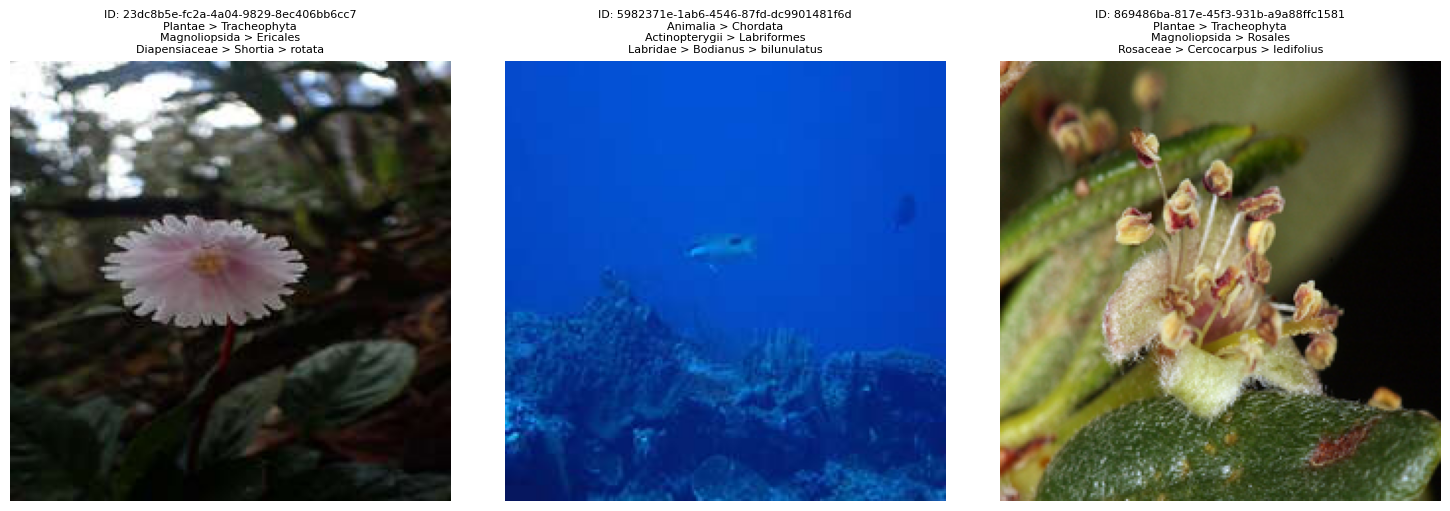

In [41]:
import matplotlib.pyplot as plt

# Randomly select 3 rows from the filtered DataFrame
random_rows = dataframe.sample(n=3)

# Initialize a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (index, row) in enumerate(random_rows.iterrows()):
    # Get the treeoflife_id and its metadata
    treeoflife_id = row["treeoflife_id"]
    kingdom = row["kingdom"]
    phylum = row["phylum"]
    _class = row["class"]
    order = row["order"]
    family = row["family"]
    genus = row["genus"]
    species = row["species"]

    # Load the corresponding image file from the zip archive
    try:
        image = load_image_from_zip(treeoflife_id, image_lookup, images_zip)

        # Display the image in the corresponding subplot
        axes[idx].imshow(image)
        axes[idx].axis('off')  # Optional: Hide axes
        axes[idx].set_title(f"ID: {treeoflife_id}\n"
                            f"{kingdom} > {phylum}\n"
                            f"{_class} > {order}\n"
                            f"{family} > {genus} > {species}",
                            fontsize=8)  # Add metadata as the title
    except FileNotFoundError as e:
        print(f"Image not found for Tree of Life ID {treeoflife_id}: {e}")
        axes[idx].axis('off')
        axes[idx].set_title("Image Not Found")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [9]:
# Encode each taxonomy level

data = dataframe.copy()
label_encoders = {}
num_classes_per_level = {}

for level in ["kingdom", "phylum", "class", "order", "family", "genus", "species"]:
    le = LabelEncoder()

    # Ensure the column contains strings and replace missing values with "unknown"
    data[level] = data[level].fillna("unknown").astype(str)

    # Filter out "unknown" before fitting
    filtered_data = data[level][data[level] != "unknown"]

    # Fit the LabelEncoder without "unknown"
    le.fit(filtered_data)

    # Add "unknown" manually with encoding -1
    classes_with_unknown = np.concatenate((["unknown"], le.classes_))
    le.classes_ = classes_with_unknown

    # Transform the data, assigning -1 to "unknown"
    data[level] = np.where(data[level] == "unknown", 0, le.transform(data[level]))
    label_encoders[level] = le

    # Log the mapping for debugging
    if level == "kingdom":
        mapping = dict(zip(le.classes_, np.arange(len(le.classes_))))
        print(f"Mapping for {level}:")
        for text_label, encoded_label in mapping.items():
            print(f"  '{text_label}' -> {encoded_label}")

    # Determine the number of unique classes
    unique_classes = data[level].unique()
    num_classes_per_level[level] = len(unique_classes)
    print(f"{level}: {len(unique_classes)} unique classes encoded.")

# Save label encoders for inference
with open("/content/drive/MyDrive/DL24/Project/label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

print("Number of classes per level:", num_classes_per_level)

Mapping for kingdom:
  'unknown' -> 0
  'Animalia' -> 1
  'Bacteria' -> 2
  'Chromista' -> 3
  'Fungi' -> 4
  'Plantae' -> 5
  'Protozoa' -> 6
  'Viridiplantae' -> 7
kingdom: 8 unique classes encoded.
phylum: 43 unique classes encoded.
class: 123 unique classes encoded.
order: 481 unique classes encoded.
family: 1692 unique classes encoded.
genus: 6035 unique classes encoded.
species: 6837 unique classes encoded.
Number of classes per level: {'kingdom': 8, 'phylum': 43, 'class': 123, 'order': 481, 'family': 1692, 'genus': 6035, 'species': 6837}


kingdom: 8 unique classes


<ipython-input-43-0b9c3933ed60>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


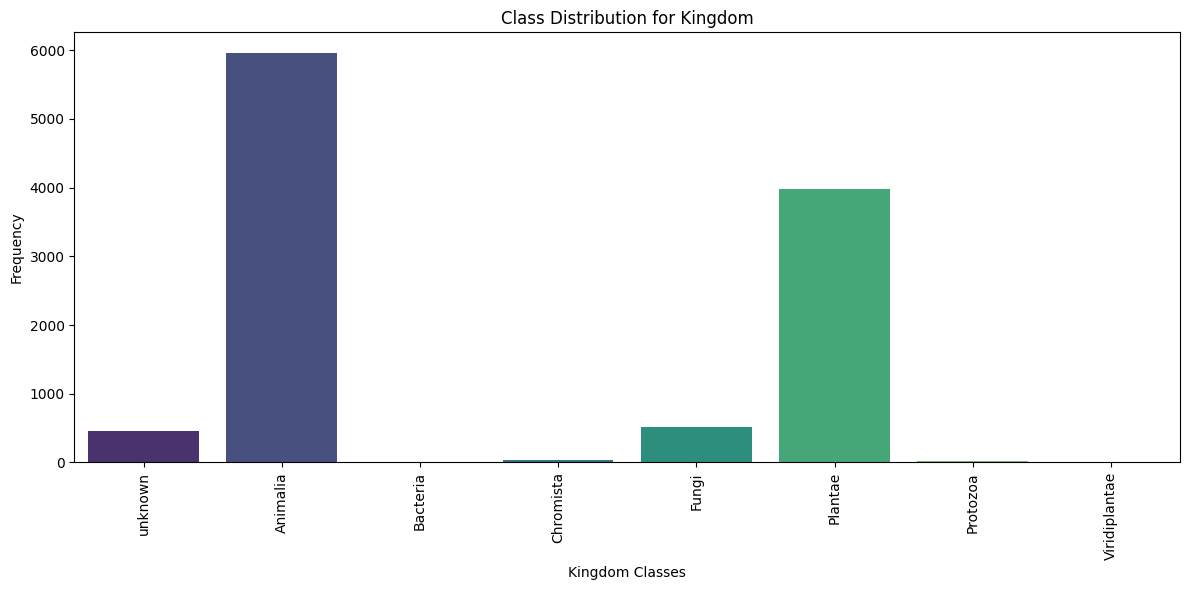

phylum: 43 unique classes


<ipython-input-43-0b9c3933ed60>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


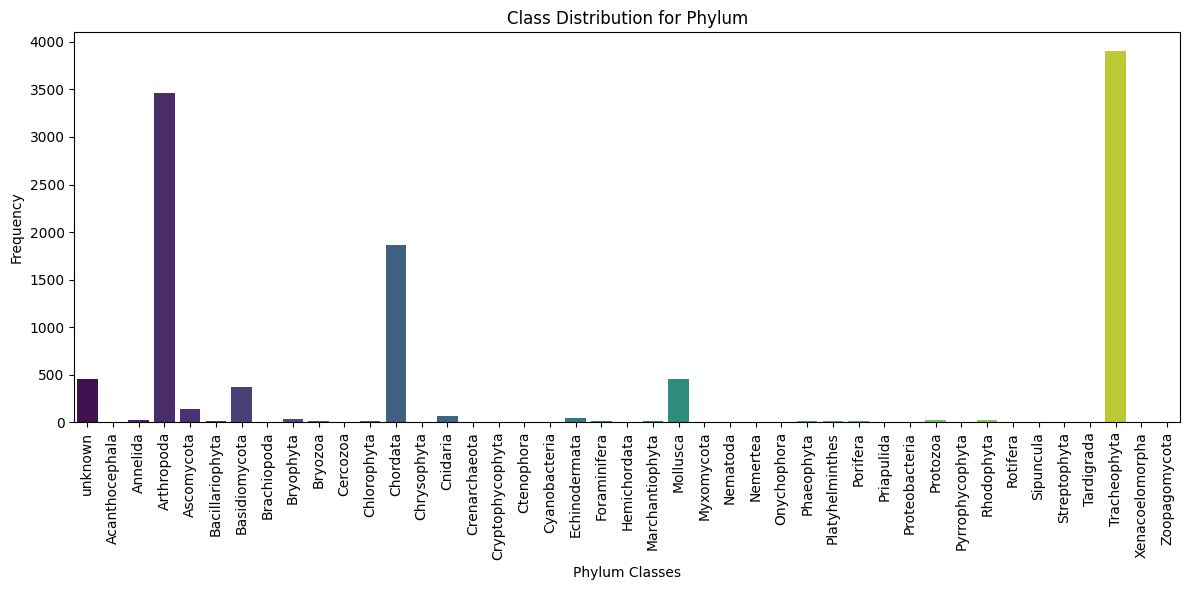

class: 123 unique classes


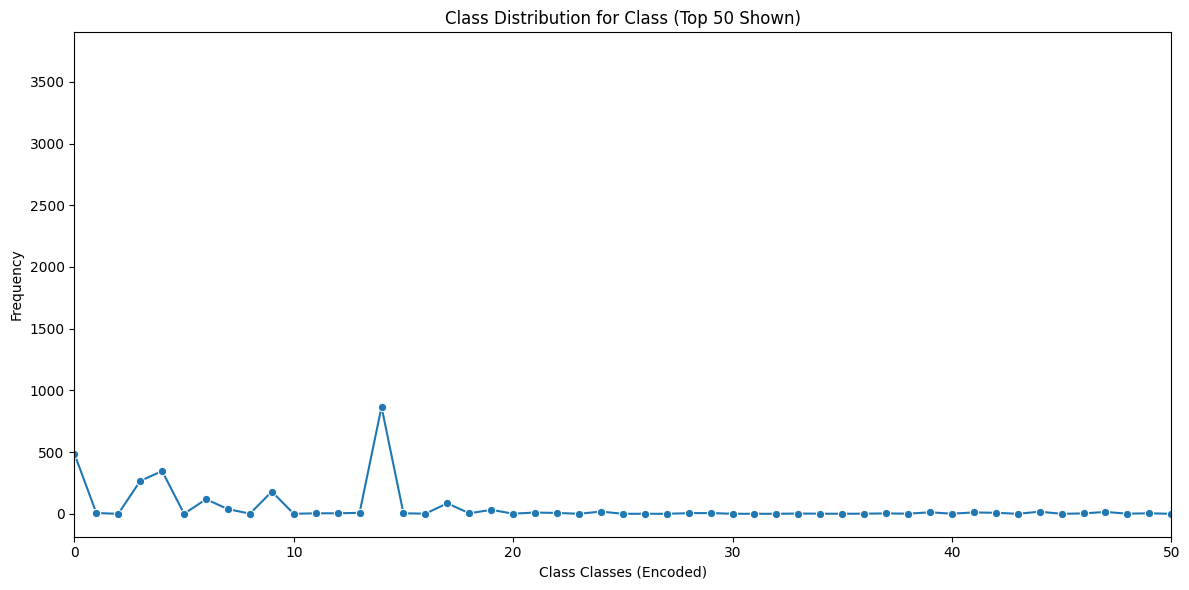

order: 481 unique classes


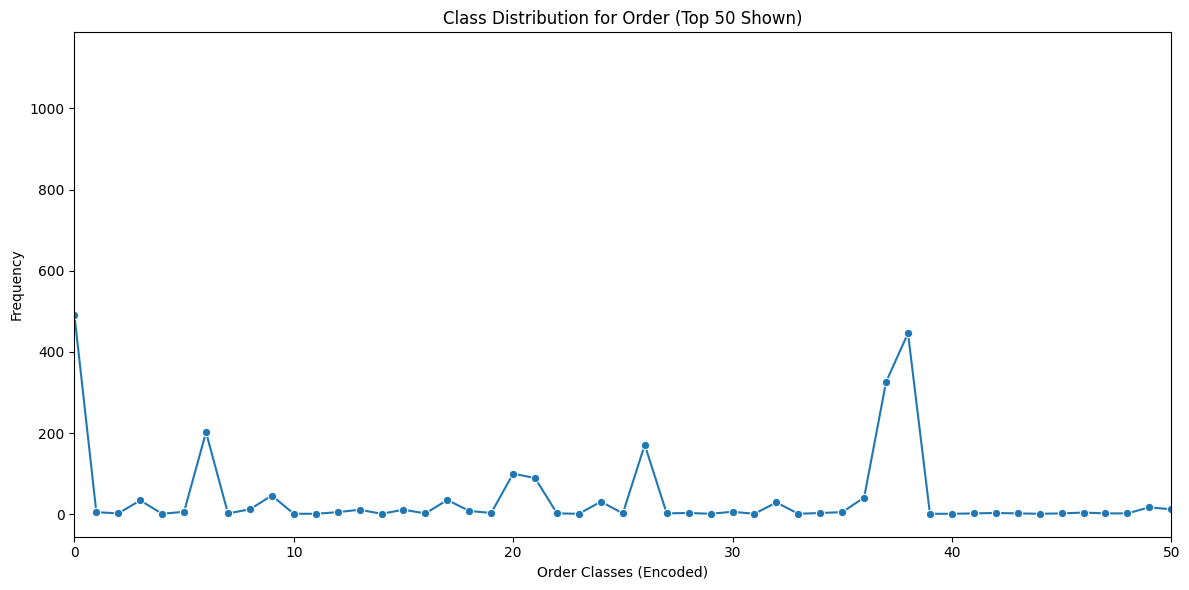

family: 1692 unique classes


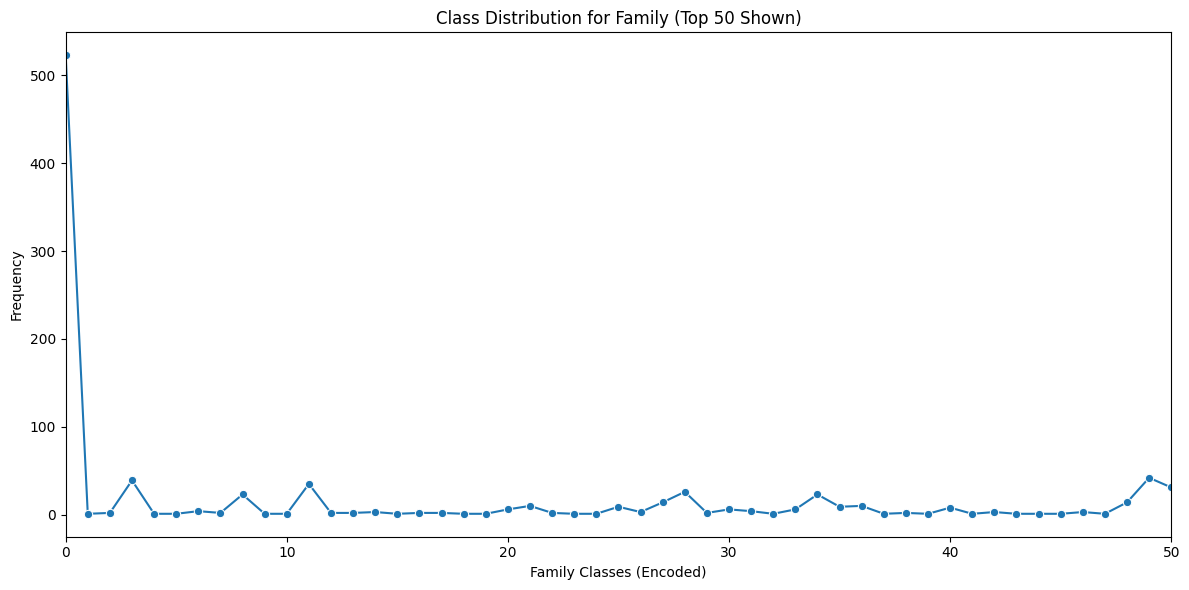

genus: 6035 unique classes


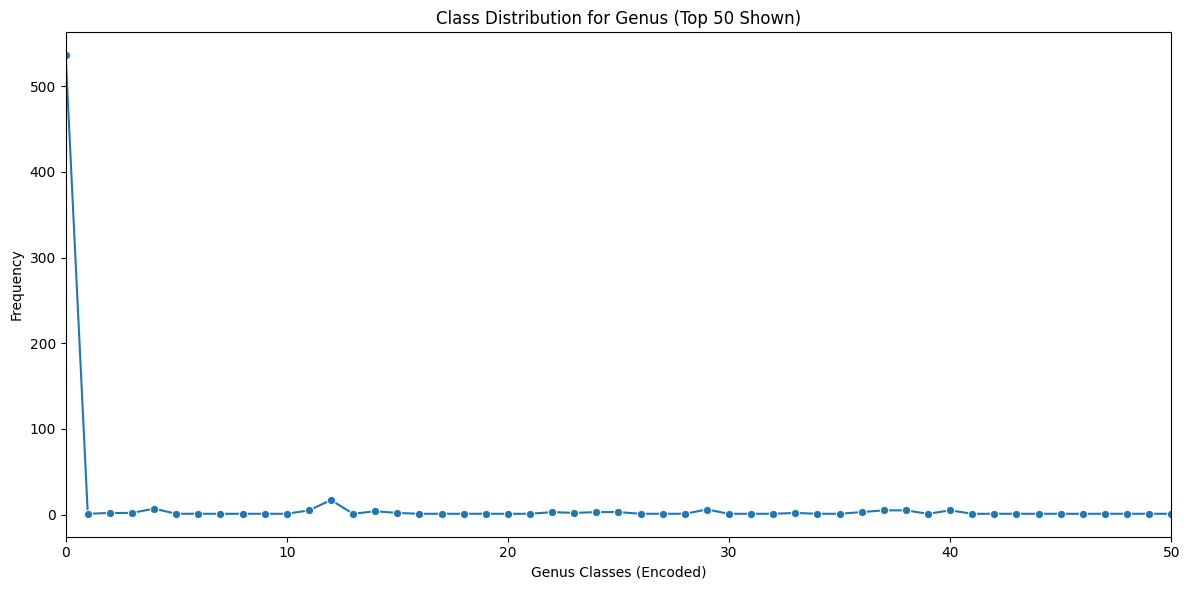

species: 6837 unique classes


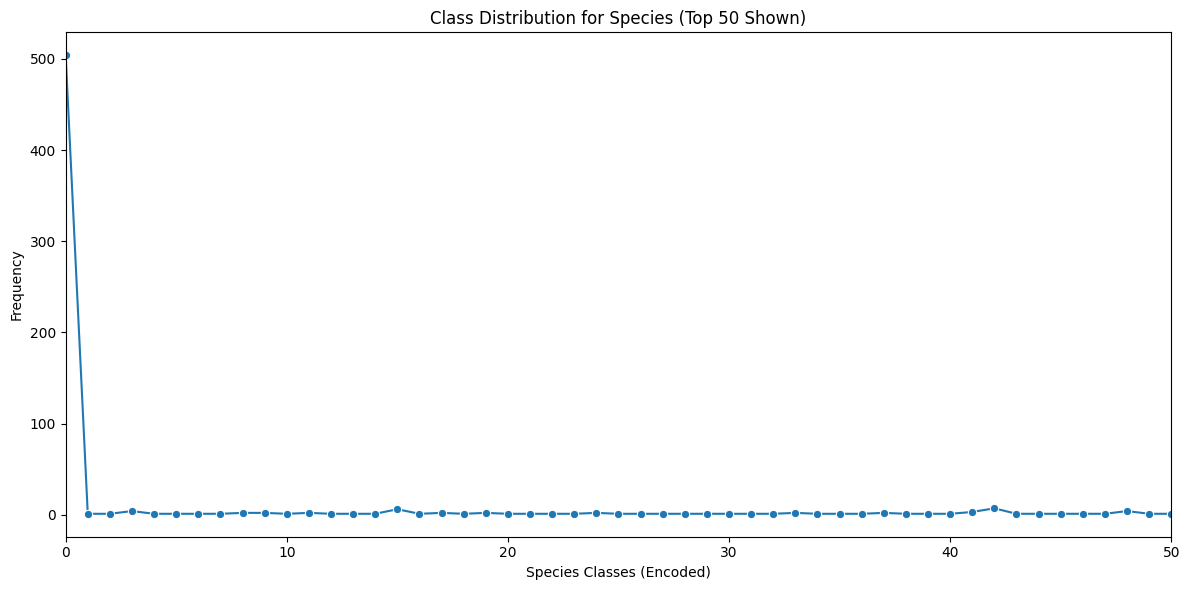


Number of classes per level:
  Kingdom: 8
  Phylum: 43
  Class: 123
  Order: 481
  Family: 1692
  Genus: 6035
  Species: 6837


In [43]:
# Copy the original dataframe
data = dataframe.copy()
label_encoders = {}
num_classes_per_level = {}

# Define taxonomic levels
levels = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]

# Encoding and class distribution visualization
for level in levels:
    le = LabelEncoder()

    # Replace missing values with "unknown" and ensure string type
    data[level] = data[level].fillna("unknown").astype(str)

    # Filter out "unknown" for fitting the encoder
    filtered_data = data[level][data[level] != "unknown"]

    # Fit the LabelEncoder and add "unknown" manually as class 0
    le.fit(filtered_data)
    le.classes_ = np.concatenate((["unknown"], le.classes_))
    data[level] = np.where(data[level] == "unknown", 0, le.transform(data[level]))
    label_encoders[level] = le

    # Count the number of unique classes and their frequencies
    unique_classes = len(le.classes_)
    class_counts = data[level].value_counts().sort_index()

    # Store the number of unique classes
    num_classes_per_level[level] = unique_classes
    print(f"{level}: {unique_classes} unique classes")

    # Visualization
    plt.figure(figsize=(12, 6))
    if len(class_counts) <= 50:  # Bar plot for levels with fewer classes
        sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
        plt.xticks(ticks=class_counts.index, labels=le.classes_, rotation=90)
        plt.title(f"Class Distribution for {level.capitalize()}")
        plt.xlabel(f"{level.capitalize()} Classes")
        plt.ylabel("Frequency")
    else:  # Line plot for levels with many classes
        sns.lineplot(x=class_counts.index, y=class_counts.values, marker="o")
        plt.title(f"Class Distribution for {level.capitalize()} (Top 50 Shown)")
        plt.xlabel(f"{level.capitalize()} Classes (Encoded)")
        plt.ylabel("Frequency")
        plt.xlim(0, 50)  # Show only top 50 classes for readability

    plt.tight_layout()
    plt.show()

# Save label encoders for future inference
with open("/content/drive/MyDrive/DL24/Project/label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

print("\nNumber of classes per level:")
for level, num_classes in num_classes_per_level.items():
    print(f"  {level.capitalize()}: {num_classes}")

In [10]:
def reverse_encoding(numeric_label, level, label_encoders):
    """
    Reverse a numeric label back to the original text label for a specific taxonomy level.

    Args:
        numeric_label (int): The numeric label to decode.
        level (str): The taxonomy level (e.g., "kingdom", "phylum", etc.).
        label_encoders (dict): A dictionary of LabelEncoders for each taxonomy level.

    Returns:
        str: The original text label.
    """
    if level not in label_encoders:
        raise ValueError(f"Label encoder for level '{level}' not found.")

    le = label_encoders[level]
    return le.inverse_transform([numeric_label])[0]

In [11]:
class TaxonomyDataset(Dataset):
    def __init__(self, dataframe, image_lookup, zip_path, transform=None):
        self.data = dataframe
        self.image_lookup = image_lookup
        self.zip_path = zip_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        treeoflife_id = row["treeoflife_id"]

        try:
            # Load image from zip file
            image = self.load_image_from_zip(treeoflife_id)
            transformed_image = self.transform(image) if self.transform else image
        except Exception as e:
            raise RuntimeError(f"Failed to load image for Tree of Life ID {treeoflife_id}: {e}")

        # Extract hierarchical labels as a dictionary
        labels = {
            "kingdom": row["kingdom"],
            "phylum": row["phylum"],
            "class": row["class"],
            "order": row["order"],
            "family": row["family"],
            "genus": row["genus"],
            "species": row["species"],
        }

        return transformed_image, labels, image

    def load_image_from_zip(self, treeoflife_id):
        """
        Load an image from the zip file given the treeoflife_id.

        Args:
        - treeoflife_id (str): The ID of the tree of life.

        Returns:
        - PIL.Image: The decompressed image.
        """
        if treeoflife_id in self.image_lookup:
            image_filename = self.image_lookup[treeoflife_id]
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                with zip_ref.open(image_filename) as image_file:
                    image = Image.open(io.BytesIO(image_file.read())).convert("RGB")
                    return image
        else:
            raise FileNotFoundError(f"Image '{treeoflife_id}.jpg' not found in the zip file.")

In [12]:
def custom_collate(batch):
    """
    Custom collate function to handle batches with both tensors and PIL Images.

    Args:
        batch (list): A list of tuples (transformed_image, labels, image).

    Returns:
        tuple: Batched transformed images, labels, and list of PIL Images.
    """
    transformed_images = torch.stack([item[0] for item in batch])  # Stack transformed tensors
    # Combine labels into a dictionary of tensors
    labels = {level: torch.tensor([item[1][level] for item in batch], dtype=torch.long)
              for level in ["kingdom", "phylum", "class", "order", "family", "genus", "species"]}
    images = [item[2] for item in batch]  # Keep raw PIL Images as a list
    return transformed_images, labels, images

In [13]:
def get_bioclip_predictions(image, classifier, label_encoders):
    """
    Get filtered and encoded BioCLIP predictions aligned with the student's known classes.

    Args:
        image (PIL.Image.Image): The input image.
        classifier (TreeOfLifeClassifier): The BioCLIP TreeOfLifeClassifier instance.
        label_encoders (dict): A dictionary of LabelEncoders for each taxonomic rank.

    Returns:
        list: Filtered, encoded, and normalized predictions from the BioCLIP model.
    """
    def clean_species_format(species, genus):
        """
        Clean the species string by removing the genus prefix if it exists.

        Args:
            species (str): The species string to check and clean.
            genus (str): The genus string.

        Returns:
            str: The cleaned species string.
        """
        if species.startswith(f"{genus} "):
            return species[len(genus) + 1:]  # Remove the genus and space
        return species

    # Save the image to a temporary file (required for pybioclip)
    temp_image_path = "/tmp/temp_image.png"
    image.save(temp_image_path, format="PNG")

    # Get predictions from the BioCLIP model
    try:
        predictions = classifier.predict(temp_image_path, Rank.SPECIES)
    except Exception as e:
        print(f"BioCLIP library error: {e}")
        return []

    # Filter and encode predictions
    filtered_predictions = []
    for pred in predictions:
        encoded_pred = {"score": pred["score"]}  # Initialize encoded prediction with score
        valid_prediction = True  # Assume valid prediction initially

        try:
            for level in ["kingdom", "phylum", "class", "order", "family", "genus", "species"]:
                # Clean species format if needed
                if level == "species":
                    pred["species"] = clean_species_format(pred["species"], pred["genus"])

                try:
                    # Encode the prediction using the label encoder
                    encoded_class = label_encoders[level].transform([pred[level]])[0]
                    encoded_pred[level] = encoded_class
                except ValueError:
                    # If the class is unknown, encode as 0
                    encoded_pred[level] = 0
                    valid_prediction = False  # Mark as partial or invalid

            # Add valid (encoded) predictions to the filtered list
            filtered_predictions.append(encoded_pred)
        except Exception as e:
            # Skip entirely invalid predictions
            print(f"Error processing prediction: {e}")
            continue

    # Normalize scores
    total_score = sum(pred['score'] for pred in filtered_predictions)
    if total_score > 0:
        for pred in filtered_predictions:
            pred['score'] /= total_score

    return filtered_predictions

[{'score': 0.8325102811319189, 'kingdom': 6, 'phylum': 33, 'class': 121, 'order': 461, 'family': 489, 'genus': 1813, 'species': 5925}, {'score': 0.09624661302302949, 'kingdom': 6, 'phylum': 33, 'class': 121, 'order': 461, 'family': 0, 'genus': 0, 'species': 0}, {'score': 0.030401497675100916, 'kingdom': 4, 'phylum': 4, 'class': 109, 'order': 222, 'family': 1072, 'genus': 0, 'species': 0}, {'score': 0.023711465287873233, 'kingdom': 1, 'phylum': 14, 'class': 67, 'order': 413, 'family': 0, 'genus': 0, 'species': 2248}, {'score': 0.0171301428820774, 'kingdom': 3, 'phylum': 0, 'class': 0, 'order': 0, 'family': 0, 'genus': 0, 'species': 5034}]
Ground Truth:
Kingdom: Protozoa (Encoded: 6)
Phylum: Protozoa (Encoded: 33)
Class: Zoomastigophora (Encoded: 121)
Order: Trichomonadida (Encoded: 461)
Family: Devescovinidae (Encoded: 489)
Genus: Devescovina (Encoded: 1813)
Species: striata (Encoded: 5925)

 Teacher Predictions:
Kingdom: 6, Phylum: 33, Class: 121, Order: 461, Family: 489, Genus: 1813, 

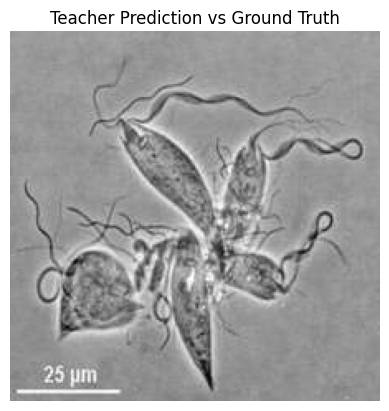

In [92]:
# TEST BioCLIP Teacher Model Predictions vs Ground Truth

image_transforms = transforms.Compose([
    transforms.ToTensor(),
])

tol_classifier = TreeOfLifeClassifier()

# Initialize dataset
dataset = TaxonomyDataset(data, image_lookup, images_zip, transform=image_transforms)

# DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)

# Grab one image and its ground truth labels from the DataLoader
transformed_image, labels, image = next(iter(loader))

# Load the label encoders
with open("/content/drive/MyDrive/DL24/Project/label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

# Decode the ground truth labels using reverse_encoding
ground_truth = {
    level: reverse_encoding(labels[level][0].item(), level, label_encoders)
    for level in ["kingdom", "phylum", "class", "order", "family", "genus", "species"]
}

# Get BioCLIP predictions for the image
# Each prediction is already in text format, so no decoding is needed
predictions = get_bioclip_predictions(image[0], tol_classifier, label_encoders)

print(predictions)

# Display ground truth labels
print("Ground Truth:")
for level, text_label in ground_truth.items():
    try:
        # Get the encoded class for the text label
        encoded_label = label_encoders[level].transform([text_label])[0]
        print(f"{level.capitalize()}: {text_label} (Encoded: {encoded_label})")
    except ValueError:
        # Handle cases where the text label is "unknown" or not found
        print(f"{level.capitalize()}: {text_label} (Encoded: Unknown)")

# Display predictions
print("\n Teacher Predictions:")
for pred in predictions:
    print(
        f"Kingdom: {pred['kingdom']}, "
        f"Phylum: {pred['phylum']}, "
        f"Class: {pred['class']}, "
        f"Order: {pred['order']}, "
        f"Family: {pred['family']}, "
        f"Genus: {pred['genus']}, "
        f"Species: {pred['species']}, "
        f"Score: {pred['score']:.4f}"
    )

# Display the image
plt.figure()
plt.imshow(image[0])
plt.axis("off")
plt.title("Teacher Prediction vs Ground Truth")
plt.show()

In [14]:

class TaxonomyTinyViT(nn.Module):
    def __init__(self, num_classes_per_level):
        """
        TinyViT model for hierarchical taxonomy classification.

        Args:
            num_classes_per_level (dict): Dictionary with the number of classes
                                          for each taxonomy level (e.g., "kingdom", "phylum").
        """
        super(TaxonomyTinyViT, self).__init__()
        self.backbone = create_model('vit_tiny_r_s16_p8_224', pretrained=True)
        self.backbone.head = nn.Identity()  # Remove the default classification head

        # Add a LayerNorm layer to normalize backbone features
        self.norm = nn.LayerNorm(192)  # 192 is the feature dimension from the backbone

        # Separate heads for each taxonomy level
        self.kingdom_head = nn.Linear(192, num_classes_per_level["kingdom"])
        self.phylum_head = nn.Linear(192, num_classes_per_level["phylum"])
        self.class_head = nn.Linear(192, num_classes_per_level["class"])
        self.order_head = nn.Linear(192, num_classes_per_level["order"])
        self.family_head = nn.Linear(192, num_classes_per_level["family"])
        self.genus_head = nn.Linear(192, num_classes_per_level["genus"])
        self.species_head = nn.Linear(192, num_classes_per_level["species"])

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Initialize the weights of the classification heads.
        """
        for head in [
            self.kingdom_head,
            self.phylum_head,
            self.class_head,
            self.order_head,
            self.family_head,
            self.genus_head,
            self.species_head,
        ]:
            nn.init.xavier_uniform_(head.weight)  # Xavier initialization
            nn.init.constant_(head.bias, 0)       # Set biases to zero

    def forward(self, x):
        """
        Forward pass of the TinyViT model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, 224, 224).

        Returns:
            tuple: Logits for each taxonomy level (kingdom, phylum, ..., species).
        """
        # Extract shared features using the backbone
        features = self.backbone(x)

        # Normalize the features using LayerNorm
        normalized_features = self.norm(features)

        logits = {
            "kingdom": self.kingdom_head(normalized_features),
            "phylum": self.phylum_head(normalized_features),
            "class": self.class_head(normalized_features),
            "order": self.order_head(normalized_features),
            "family": self.family_head(normalized_features),
            "genus": self.genus_head(normalized_features),
            "species": self.species_head(normalized_features),
        }

        return logits


In [15]:
# Test initializing model architecture

num_classes_per_level_test = {
    level: len(le.classes_) for level, le in label_encoders.items()
}

try:
    # Initialize the model with test parameters
    model_test = TaxonomyTinyViT(num_classes_per_level_test)

    # Generate a dummy input tensor
    dummy_input = torch.randn(1, 3, 224, 224)  # Batch size 1, image size 224x224

    # Perform a forward pass
    logits = model_test(dummy_input)

    # Print the output shapes for each taxonomy level
    for level, output in logits.items():
        print(f"{level}: {output.shape}")
except Exception as e:
    print(f"Error during testing: {e}")

kingdom: torch.Size([1, 8])
phylum: torch.Size([1, 43])
class: torch.Size([1, 123])
order: torch.Size([1, 481])
family: torch.Size([1, 1692])
genus: torch.Size([1, 6035])
species: torch.Size([1, 6837])


In [16]:
def hierarchical_loss_with_top1(student_logits, hard_labels, teacher_top1, alpha=0.5, level_weights=None):
    """
    Computes the combined hierarchical loss, skipping levels where the teacher predicts "unknown"
    but still using other levels with valid predictions.

    Args:
        student_logits (dict): Logits for each taxonomy level.
        hard_labels (dict): Ground truth labels for each taxonomy level.
        teacher_top1 (dict): Teacher's top-1 predictions for each taxonomy level and scores in batch form.
                             teacher_top1[level]: Tensor of shape (batch_size,) containing the top-1 prediction for each image.
                             teacher_top1["score"]: Tensor of shape (batch_size,) containing the corresponding scores.
        alpha (float): Balance between hard and soft label losses (0.0 to 1.0).
        level_weights (dict): Optional weights for each taxonomy level.

    Returns:
        torch.Tensor: Combined loss.
    """
    # Initialize loss components
    total_loss = 0.0

    # Default level weights to 1 if not provided
    if level_weights is None:
        level_weights = {level: 1.0 for level in student_logits.keys()}

    # Define loss functions
    hard_loss_fn = nn.CrossEntropyLoss()
    soft_loss_fn = nn.KLDivLoss(reduction="batchmean")

    # Hard label loss
    hard_loss = 0.0
    for level in student_logits.keys():
        hard_loss += (
            level_weights[level] * hard_loss_fn(student_logits[level], hard_labels[level])
        )

    # Soft label loss using teacher's top-1 prediction
    soft_loss = 0.0
    for level in student_logits.keys():
        # Get the teacher's top-1 predictions and probabilities for this level
        teacher_labels = teacher_top1[level]  # Tensor of shape (batch_size,)
        teacher_probs = teacher_top1["score"]  # Tensor of shape (batch_size,)

        # Create a target distribution for the teacher's soft labels
        batch_size = teacher_labels.shape[0]
        target_distribution = torch.zeros_like(student_logits[level])  # Shape: (batch_size, num_classes)

        for i in range(batch_size):
            if teacher_labels[i] != 0:  # Only process known teacher predictions
                target_distribution[i, teacher_labels[i]] = teacher_probs[i]

        # Compute KL Divergence loss for this level
        soft_loss += level_weights[level] * soft_loss_fn(
            F.log_softmax(student_logits[level], dim=1), target_distribution
        )

    # Combine hard and soft losses
    total_loss = alpha * hard_loss + (1 - alpha) * soft_loss
    return total_loss

In [17]:
# Evaluating performance on the validation or test set doesn't use a loss function with the teacher model

def hierarchical_validation_loss(student_logits, hard_labels, level_weights=None):
    """
    Computes the validation loss based on hard labels only.

    Args:
        student_logits (dict): Logits for each taxonomy level.
        hard_labels (dict): Ground truth labels for each taxonomy level.
        level_weights (dict): Optional weights for each taxonomy level.

    Returns:
        torch.Tensor: Validation loss.
    """
    # Initialize loss components
    total_loss = 0.0

    # Default level weights to 1 if not provided
    if level_weights is None:
        level_weights = {level: 1.0 for level in student_logits.keys()}

    # Define loss function
    hard_loss_fn = nn.CrossEntropyLoss()

    # Hard label loss
    for level in student_logits.keys():
        total_loss += (
            level_weights[level] * hard_loss_fn(student_logits[level], hard_labels[level])
        )

    return total_loss

In [18]:
# Create train, val, test splits and initialize data loaders

# Split the dataset into training, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print(f"Training size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TaxonomyDataset(
    dataframe=train_data,
    image_lookup=image_lookup,
    zip_path=images_zip,
    transform=train_transforms
)

val_dataset = TaxonomyDataset(
    dataframe=val_data,
    image_lookup=image_lookup,
    zip_path=images_zip,
    transform=val_test_transforms
)

test_dataset = TaxonomyDataset(
    dataframe=test_data,
    image_lookup=image_lookup,
    zip_path=images_zip,
    transform=val_test_transforms
)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

Training size: 6587
Validation size: 2196
Test size: 2196


In [19]:


def train_one_epoch(student_model, train_loader, teacher_model, label_encoders, optimizer, epoch, alpha=0.5):
    student_model.train()  # Set model to training mode
    running_loss = 0.0

    # Initialize gradient scaler for mixed precision
    scaler = GradScaler()

    # Iterate through the training DataLoader
    for batch_idx, (transformed_images, hard_labels, raw_images) in enumerate(tqdm(train_loader)):
        try:
            # Move data to the device
            transformed_images = transformed_images.to(device)
            for level in hard_labels.keys():
                hard_labels[level] = hard_labels[level].to(device)

            # Get teacher predictions for the raw images
            teacher_predictions = []
            for img in raw_images:
                # Get all predictions from the teacher model
                all_teacher_preds = get_bioclip_predictions(img, teacher_model, label_encoders)

                if all_teacher_preds:
                    # Select the prediction with the highest score
                    top_pred = max(all_teacher_preds, key=lambda x: x['score'])
                    teacher_predictions.append(top_pred)
                else:
                    # Handle cases where no valid predictions are returned
                    print(f"Warning: No valid predictions for an image.")
                    teacher_predictions.append({
                        "score": 0.0,
                        "kingdom": 0,
                        "phylum": 0,
                        "class": 0,
                        "order": 0,
                        "family": 0,
                        "genus": 0,
                        "species": 0
                    })

            # Convert teacher predictions into a batch structure
            teacher_batch = {
                level: torch.tensor([pred[level] for pred in teacher_predictions], device=device)
                for level in ["kingdom", "phylum", "class", "order", "family", "genus", "species"]
            }
            teacher_batch["score"] = torch.tensor(
                [pred["score"] for pred in teacher_predictions], device=device
            )

            # Forward pass with mixed precision
            with autocast(device_type='cuda'):
                student_logits = student_model(transformed_images)
                loss = loss_function(student_logits, hard_labels, teacher_batch, alpha=alpha)

            # Backward pass and optimization with scaled gradients
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Track loss
            running_loss += loss.item()

        except RuntimeError as e:
            print(f"Error in batch {batch_idx}: {e}")
            raise

    # Average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch} - Training Loss: {avg_loss:.4f}")
    return avg_loss


In [20]:
def evaluate_model_with_predictions(model, data_loader, loss_function):
    """
    Evaluate the model on the validation dataset.

    Args:
        model (nn.Module): The student model.
        data_loader (DataLoader): Validation data loader.
        loss_function (function): The loss function to compute validation loss.

    Returns:
        tuple: Average validation loss, all predictions, all labels.
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_predictions = {level: [] for level in ["kingdom", "phylum", "class", "order", "family", "genus", "species"]}
    all_labels = {level: [] for level in ["kingdom", "phylum", "class", "order", "family", "genus", "species"]}

    with torch.no_grad():
        for batch_idx, (images, hard_labels, _) in enumerate(data_loader):
            images = images.to(device)
            for level in hard_labels.keys():
                hard_labels[level] = hard_labels[level].to(device)

            # Forward pass
            logits = model(images)

            # Compute loss
            loss = loss_function(logits, hard_labels)
            running_loss += loss.item()

            # Collect predictions and labels
            for level in logits.keys():
                if batch_idx == 0:
                    print(f"Logits shape for level {level} in batch: {logits[level].shape}")  # Debug print

                all_predictions[level].append(logits[level].cpu())  # Store logits as separate batches
                all_labels[level].append(hard_labels[level].cpu())  # Store labels as separate batches

    # Concatenate logits and labels for each level
    for level in all_predictions.keys():
        all_predictions[level] = torch.cat(all_predictions[level], dim=0)  # Stack along batch dimension
        all_labels[level] = torch.cat(all_labels[level], dim=0)

    avg_loss = running_loss / len(data_loader)
    return avg_loss, all_predictions, all_labels


In [21]:


def evaluate_teacher_model(teacher_model, data_loader, label_encoders):
    """
    Evaluate the teacher model (BioCLIP) on the validation dataset.

    Args:
        teacher_model (TreeOfLifeClassifier): The BioCLIP TreeOfLifeClassifier instance.
        data_loader (DataLoader): Validation data loader.
        label_encoders (dict): A dictionary of LabelEncoders for each taxonomic rank.

    Returns:
        tuple: Teacher predictions and ground truth labels for all taxonomic levels.
    """
    all_predictions = {level: [] for level in label_encoders.keys()}
    all_labels = {level: [] for level in label_encoders.keys()}

    with torch.no_grad():
        for batch_idx, (_, hard_labels, raw_images) in enumerate(data_loader):
            for i, image in enumerate(raw_images):
                # Get teacher predictions for the raw image
                teacher_preds = get_bioclip_predictions(image, teacher_model, label_encoders)

                if teacher_preds:
                    # Use the top prediction for simplicity
                    top_pred = max(teacher_preds, key=lambda x: x['score'])
                else:
                    # Handle cases where no valid predictions are returned
                    top_pred = {level: 0 for level in label_encoders.keys()}  # Default to 0 for all levels

                # Append teacher predictions
                for level in label_encoders.keys():
                    logits = torch.zeros(len(label_encoders[level].classes_))  # Simulate logits
                    logits[top_pred[level]] = top_pred["score"]  # Set the score for the predicted class
                    all_predictions[level].append(logits)

                # Append ground truth labels
                for level in label_encoders.keys():
                    true_label = hard_labels[level][i].item()  # Extract true label from hard_labels
                    all_labels[level].append(true_label)

    # Convert predictions and labels to tensors for consistency
    for level in all_predictions.keys():
        all_predictions[level] = torch.stack(all_predictions[level])  # Convert logits to a tensor
        all_labels[level] = torch.tensor(all_labels[level])

    return all_predictions, all_labels


In [22]:
def compute_top_k_accuracy(logits, labels, k=3):
    """
    Compute Top-k Accuracy for a single taxonomic level.

    Args:
        logits (torch.Tensor): Logits of shape (batch_size, num_classes).
        labels (torch.Tensor): True labels of shape (batch_size,).
        k (int): Number of top predictions to consider.

    Returns:
        float: Top-k accuracy.
    """

    print(f"Logits shape before top-k: {logits.shape}")

    # Get the top-k predictions
    top_k_preds = torch.topk(logits, k=k, dim=1).indices  # Shape: (batch_size, k)

    # Check if the true label is in the top-k predictions
    correct = 0
    for i in range(labels.size(0)):
        if labels[i] in top_k_preds[i]:
            correct += 1

    # Compute accuracy
    return correct / labels.size(0)


In [23]:
def compute_metrics(predictions, ground_truth, top_k_list=[1, 5]):
    """
    Compute accuracy for each taxonomic level, precision, recall, F1, and top-k accuracy.

    Args:
        predictions (dict): Predictions for each taxonomic level (logits or discrete).
        ground_truth (dict): Ground truth labels for each taxonomic level.
        top_k_list (list): List of k values for Top-k accuracy computation.

    Returns:
        dict: Metrics including accuracy, optionally precision, recall, F1 score, and top-k accuracy.
    """
    metrics = {
        "accuracy": {},
        "precision": {},
        "recall": {},
        "f1_score": {},
        "top_k": {k: {} for k in top_k_list},
    }

    for level in predictions.keys():
        preds = predictions[level]
        labels = ground_truth[level]

        # Check if predictions are logits (for student model) or discrete (for teacher)
        if preds.ndim == 2:  # Logits, need to compute class predictions
            preds = torch.argmax(preds, dim=1)

        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        # Compute accuracy
        metrics["accuracy"][level] = accuracy_score(labels, preds)

        # Compute precision, recall, and F1 score
        metrics["precision"][level] = precision_score(labels, preds, average="macro", zero_division=0)
        metrics["recall"][level] = recall_score(labels, preds, average="macro", zero_division=0)
        metrics["f1_score"][level] = f1_score(labels, preds, average="macro", zero_division=0)

        # Compute Top-k accuracy for logits only
        if preds.ndim == 1:  # Skip top-k accuracy if not logits
            logits = predictions[level]
            for k in top_k_list:
                if logits.ndim == 2:  # Check again to ensure top-k is only calculated on logits
                    top_k_acc = compute_top_k_accuracy(logits, ground_truth[level], k=k)
                    metrics["top_k"][k][level] = top_k_acc

    return metrics


In [24]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        patience (int): How long to wait after the last time the validation loss improved.
        verbose (bool): If True, prints a message for each validation loss improvement.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """
    def __init__(self, patience=3, verbose=False, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            # Save the initial model as the best model
            self.best_loss = val_loss
            self.best_model = {k: v.cpu() for k, v in model.state_dict().items()}
            if self.verbose:
                print(f"Initial validation loss: {val_loss:.4f}")
        elif val_loss < self.best_loss - self.delta:
            # Improvement in validation loss
            self.best_loss = val_loss
            self.best_model = {k: v.cpu() for k, v in model.state_dict().items()}
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.4f}. Model checkpoint updated.")
        else:
            # No improvement in validation loss
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss for {self.counter} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}...")

# Determine the number of classes for each taxonomy level
num_classes_per_level = {
    level: len(le.classes_) for level, le in label_encoders.items()
}
print(f"Number of classes per level: {num_classes_per_level}")

# Hyperparameters
learning_rate = 1e-4
weight_decay = 1e-5
loss_weighting = 0.5
num_epochs = 60  # Total training epochs
patience = 3      # Early stopping patience
stopping_delta = 0.01  # Minimum change in validation loss to qualify as an improvement
model_save_path = "/content/drive/MyDrive/DL24/Project/student_model.pth"

# Initialize model, optimizer, and loss function
student_model = TaxonomyTinyViT(num_classes_per_level).to(device)
teacher_model = TreeOfLifeClassifier()
optimizer = optim.AdamW(student_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Decay LR every 3 epochs
loss_function = hierarchical_loss_with_top1

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=patience, verbose=True, delta=stopping_delta)

Using device: cuda...
Number of classes per level: {'kingdom': 8, 'phylum': 43, 'class': 123, 'order': 481, 'family': 1692, 'genus': 6035, 'species': 6837}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

txt_emb_species.npy:   0%|          | 0.00/787M [00:00<?, ?B/s]

txt_emb_species.json:   0%|          | 0.00/65.7M [00:00<?, ?B/s]

In [26]:
# Initialize tracking variables
train_losses = []
val_losses = []
train_accuracy = {level: [] for level in ["kingdom", "phylum", "class", "order", "family", "genus", "species"]}
val_accuracy = {level: [] for level in ["kingdom", "phylum", "class", "order", "family", "genus", "species"]}

# Training loop
for epoch in range(1, num_epochs + 1):
    print(f"\n=== Starting Epoch {epoch}/{num_epochs} ===")

    # Train for one epoch
    train_loss = train_one_epoch(
        student_model, train_loader, teacher_model, label_encoders, optimizer, epoch, alpha=loss_weighting
    )
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_loss, val_preds, val_labels = evaluate_model_with_predictions(
        student_model, val_loader, hierarchical_validation_loss
    )
    val_losses.append(val_loss)

    # Debugging: Check structure of val_preds and val_labels
    # print(f"Validation Loss: {val_loss:.4f}")
    # for level in val_preds.keys():
    #     print(f"Level: {level}, Preds shape: {val_preds[level].shape}, Labels shape: {val_labels[level].shape}")

    # Compute per-level accuracy
    for level in val_preds.keys():
        try:
            # Debugging: Validate data shapes for accuracy calculation
            print(f"Computing accuracy for level {level}...")
            predicted_classes = torch.argmax(val_preds[level], dim=1).cpu().numpy()
            true_labels = val_labels[level].cpu().numpy()

            val_acc = accuracy_score(true_labels, predicted_classes)
            val_accuracy[level].append(val_acc)
        except Exception as e:
            print(f"Error computing accuracy for level {level}: {e}")

    print(f"Epoch {epoch} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    for level in val_accuracy.keys():
        if val_accuracy[level]:  # Ensure the list is not empty
            print(f"Level: {level}, Validation Accuracy: {val_accuracy[level][-1]:.4f}")
        else:
            print(f"Level: {level}, Validation Accuracy: No data")

    # Early stopping check
    early_stopping(val_loss, student_model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    # Step the learning rate scheduler
    scheduler.step()

# Save the model after training
torch.save(student_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# After all epochs, compute detailed metrics
final_metrics = compute_metrics(val_preds, val_labels, top_k_list=[1, 5])

# Evaluate teacher model performance
teacher_preds, teacher_labels = evaluate_teacher_model(teacher_model, val_loader, label_encoders)
teacher_metrics = compute_metrics(teacher_preds, teacher_labels, top_k_list=[1, 5])

# Print detailed metrics
print("\n=== Final Student Metrics ===")
for level in final_metrics["accuracy"].keys():
    print(f"Level: {level}, Final Accuracy: {final_metrics['accuracy'][level]:.4f}")
    print(f"  Precision: {final_metrics['precision'][level]:.4f}")
    print(f"  Recall: {final_metrics['recall'][level]:.4f}")
    print(f"  F1 Score: {final_metrics['f1_score'][level]:.4f}")
    for k in final_metrics["top_k"].keys():
        print(f"  Top-{k} Accuracy: {final_metrics['top_k'][k][level]:.4f}")

print("\n=== Teacher Model Metrics ===")
for level in teacher_metrics["accuracy"].keys():
    print(f"Level: {level}, Accuracy: {teacher_metrics['accuracy'][level]:.4f}")
    print(f"  Precision: {teacher_metrics['precision'][level]:.4f}")
    print(f"  Recall: {teacher_metrics['recall'][level]:.4f}")
    print(f"  F1 Score: {teacher_metrics['f1_score'][level]:.4f}")
    for k in teacher_metrics["top_k"].keys():
        print(f"  Top-{k} Accuracy: {teacher_metrics['top_k'][k][level]:.4f}")





=== Starting Epoch 1/60 ===


100%|██████████| 206/206 [34:09<00:00,  9.95s/it]


Epoch 1 - Training Loss: 23.1312
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 1 - Training Loss: 23.1312, Validation Loss: 30.4602
Level: kingdom, Validation Accuracy: 0.8811
Level: phylum, Validation Accuracy: 0.7946
Level: class, Validation Accuracy: 0.7140
Level: order, Validation Accuracy: 0.2682
Level: family, Validation Accura

100%|██████████| 206/206 [31:46<00:00,  9.25s/it]


Epoch 2 - Training Loss: 19.6193
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 2 - Training Loss: 19.6193, Validation Loss: 29.9727
Level: kingdom, Validation Accuracy: 0.8579
Level: phylum, Validation Accuracy: 0.7864
Level: class, Validation Accuracy: 0.7209
Level: order, Validation Accuracy: 0.3060
Level: family, Validation Accura

100%|██████████| 206/206 [31:29<00:00,  9.17s/it]


Epoch 3 - Training Loss: 18.2085
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 3 - Training Loss: 18.2085, Validation Loss: 29.3932
Level: kingdom, Validation Accuracy: 0.8893
Level: phylum, Validation Accuracy: 0.8238
Level: class, Validation Accuracy: 0.7441
Level: order, Validation Accuracy: 0.3420
Level: family, Validation Accura

100%|██████████| 206/206 [31:30<00:00,  9.18s/it]


Epoch 4 - Training Loss: 17.0708
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 4 - Training Loss: 17.0708, Validation Loss: 29.1005
Level: kingdom, Validation Accuracy: 0.8925
Level: phylum, Validation Accuracy: 0.8361
Level: class, Validation Accuracy: 0.7609
Level: order, Validation Accuracy: 0.3447
Level: family, Validation Accura

100%|██████████| 206/206 [31:33<00:00,  9.19s/it]


Epoch 5 - Training Loss: 16.8470
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 5 - Training Loss: 16.8470, Validation Loss: 29.0607
Level: kingdom, Validation Accuracy: 0.8953
Level: phylum, Validation Accuracy: 0.8329
Level: class, Validation Accuracy: 0.7618
Level: order, Validation Accuracy: 0.3484
Level: family, Validation Accura

100%|██████████| 206/206 [31:36<00:00,  9.20s/it]


Epoch 6 - Training Loss: 16.6852
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 6 - Training Loss: 16.6852, Validation Loss: 29.0599
Level: kingdom, Validation Accuracy: 0.8953
Level: phylum, Validation Accuracy: 0.8338
Level: class, Validation Accuracy: 0.7641
Level: order, Validation Accuracy: 0.3502
Level: family, Validation Accura

100%|██████████| 206/206 [31:29<00:00,  9.17s/it]


Epoch 7 - Training Loss: 16.5601
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 7 - Training Loss: 16.5601, Validation Loss: 29.0262
Level: kingdom, Validation Accuracy: 0.8966
Level: phylum, Validation Accuracy: 0.8320
Level: class, Validation Accuracy: 0.7646
Level: order, Validation Accuracy: 0.3575
Level: family, Validation Accura

100%|██████████| 206/206 [31:30<00:00,  9.18s/it]


Epoch 8 - Training Loss: 16.5341
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 8 - Training Loss: 16.5341, Validation Loss: 29.0173
Level: kingdom, Validation Accuracy: 0.8957
Level: phylum, Validation Accuracy: 0.8329
Level: class, Validation Accuracy: 0.7628
Level: order, Validation Accuracy: 0.3593
Level: family, Validation Accura

100%|██████████| 206/206 [33:00<00:00,  9.61s/it]


Epoch 9 - Training Loss: 16.5091
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 9 - Training Loss: 16.5091, Validation Loss: 29.0129
Level: kingdom, Validation Accuracy: 0.8957
Level: phylum, Validation Accuracy: 0.8356
Level: class, Validation Accuracy: 0.7650
Level: order, Validation Accuracy: 0.3597
Level: family, Validation Accura

100%|██████████| 206/206 [33:07<00:00,  9.65s/it]


Epoch 10 - Training Loss: 16.4959
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 10 - Training Loss: 16.4959, Validation Loss: 29.0124
Level: kingdom, Validation Accuracy: 0.8957
Level: phylum, Validation Accuracy: 0.8356
Level: class, Validation Accuracy: 0.7646
Level: order, Validation Accuracy: 0.3597
Level: family, Validation Accu

100%|██████████| 206/206 [31:37<00:00,  9.21s/it]


Epoch 11 - Training Loss: 16.4981
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 11 - Training Loss: 16.4981, Validation Loss: 29.0125
Level: kingdom, Validation Accuracy: 0.8957
Level: phylum, Validation Accuracy: 0.8356
Level: class, Validation Accuracy: 0.7637
Level: order, Validation Accuracy: 0.3593
Level: family, Validation Accu

100%|██████████| 206/206 [31:36<00:00,  9.20s/it]


Epoch 12 - Training Loss: 16.4975
Logits shape for level kingdom in batch: torch.Size([32, 8])
Logits shape for level phylum in batch: torch.Size([32, 43])
Logits shape for level class in batch: torch.Size([32, 123])
Logits shape for level order in batch: torch.Size([32, 481])
Logits shape for level family in batch: torch.Size([32, 1692])
Logits shape for level genus in batch: torch.Size([32, 6035])
Logits shape for level species in batch: torch.Size([32, 6837])
Computing accuracy for level kingdom...
Computing accuracy for level phylum...
Computing accuracy for level class...
Computing accuracy for level order...
Computing accuracy for level family...
Computing accuracy for level genus...
Computing accuracy for level species...
Epoch 12 - Training Loss: 16.4975, Validation Loss: 29.0126
Level: kingdom, Validation Accuracy: 0.8957
Level: phylum, Validation Accuracy: 0.8356
Level: class, Validation Accuracy: 0.7632
Level: order, Validation Accuracy: 0.3588
Level: family, Validation Accu

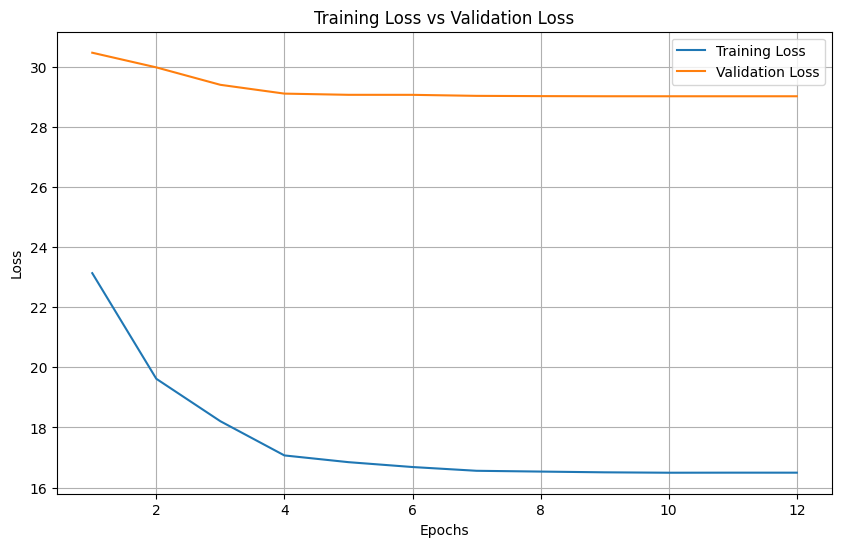

In [46]:
# Assume train_losses and val_losses are lists storing loss values for each epoch
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
saved_metrics = {
    "student": {
        "kingdom": {
            "Accuracy": 0.8957,
            "Precision": 0.3478,
            "Recall": 0.3209,
            "F1 Score": 0.3232,
            "Top-1 Accuracy": 0.8957,
            "Top-5 Accuracy": 0.9959
        },
        "phylum": {
            "Accuracy": 0.8356,
            "Precision": 0.1635,
            "Recall": 0.1489,
            "F1 Score": 0.1488,
            "Top-1 Accuracy": 0.8356,
            "Top-5 Accuracy": 0.9577
        },
        "class": {
            "Accuracy": 0.7632,
            "Precision": 0.1258,
            "Recall": 0.1057,
            "F1 Score": 0.1067,
            "Top-1 Accuracy": 0.7632,
            "Top-5 Accuracy": 0.9135
        },
        "order": {
            "Accuracy": 0.3588,
            "Precision": 0.0423,
            "Recall": 0.0507,
            "F1 Score": 0.0401,
            "Top-1 Accuracy": 0.3588,
            "Top-5 Accuracy": 0.6025
        },
        "family": {
            "Accuracy": 0.1148,
            "Precision": 0.0063,
            "Recall": 0.0118,
            "F1 Score": 0.0062,
            "Top-1 Accuracy": 0.1148,
            "Top-5 Accuracy": 0.2646
        },
        "genus": {
            "Accuracy": 0.0492,
            "Precision": 0.0006,
            "Recall": 0.0016,
            "F1 Score": 0.0006,
            "Top-1 Accuracy": 0.0492,
            "Top-5 Accuracy": 0.0733
        },
        "species": {
            "Accuracy": 0.0428,
            "Precision": 0.0,
            "Recall": 0.0005,
            "F1 Score": 0.0,
            "Top-1 Accuracy": 0.0428,
            "Top-5 Accuracy": 0.0528
        }
    },
    "teacher": {
        "kingdom": {
            "Accuracy": 0.9217,
            "Precision": 0.5233,
            "Recall": 0.6122,
            "F1 Score": 0.5587,
            "Top-1 Accuracy": 0.9217,
            "Top-5 Accuracy": 0.9709
        },
        "phylum": {
            "Accuracy": 0.8980,
            "Precision": 0.4717,
            "Recall": 0.5006,
            "F1 Score": 0.4770,
            "Top-1 Accuracy": 0.8980,
            "Top-5 Accuracy": 0.8998
        },
        "class": {
            "Accuracy": 0.8693,
            "Precision": 0.4897,
            "Recall": 0.5441,
            "F1 Score": 0.5008,
            "Top-1 Accuracy": 0.8693,
            "Top-5 Accuracy": 0.8698
        },
        "order": {
            "Accuracy": 0.7313,
            "Precision": 0.5040,
            "Recall": 0.5079,
            "F1 Score": 0.4914,
            "Top-1 Accuracy": 0.7313,
            "Top-5 Accuracy": 0.7719
        },
        "family": {
            "Accuracy": 0.6298,
            "Precision": 0.4480,
            "Recall": 0.4593,
            "F1 Score": 0.4397,
            "Top-1 Accuracy": 0.6298,
            "Top-5 Accuracy": 0.6662
        },
        "genus": {
            "Accuracy": 0.5123,
            "Precision": 0.4151,
            "Recall": 0.4184,
            "F1 Score": 0.4103,
            "Top-1 Accuracy": 0.5123,
            "Top-5 Accuracy": 0.5269
        },
        "species": {
            "Accuracy": 0.3379,
            "Precision": 0.2765,
            "Recall": 0.2758,
            "F1 Score": 0.2709,
            "Top-1 Accuracy": 0.3379,
            "Top-5 Accuracy": 0.3520
        }
    }
}


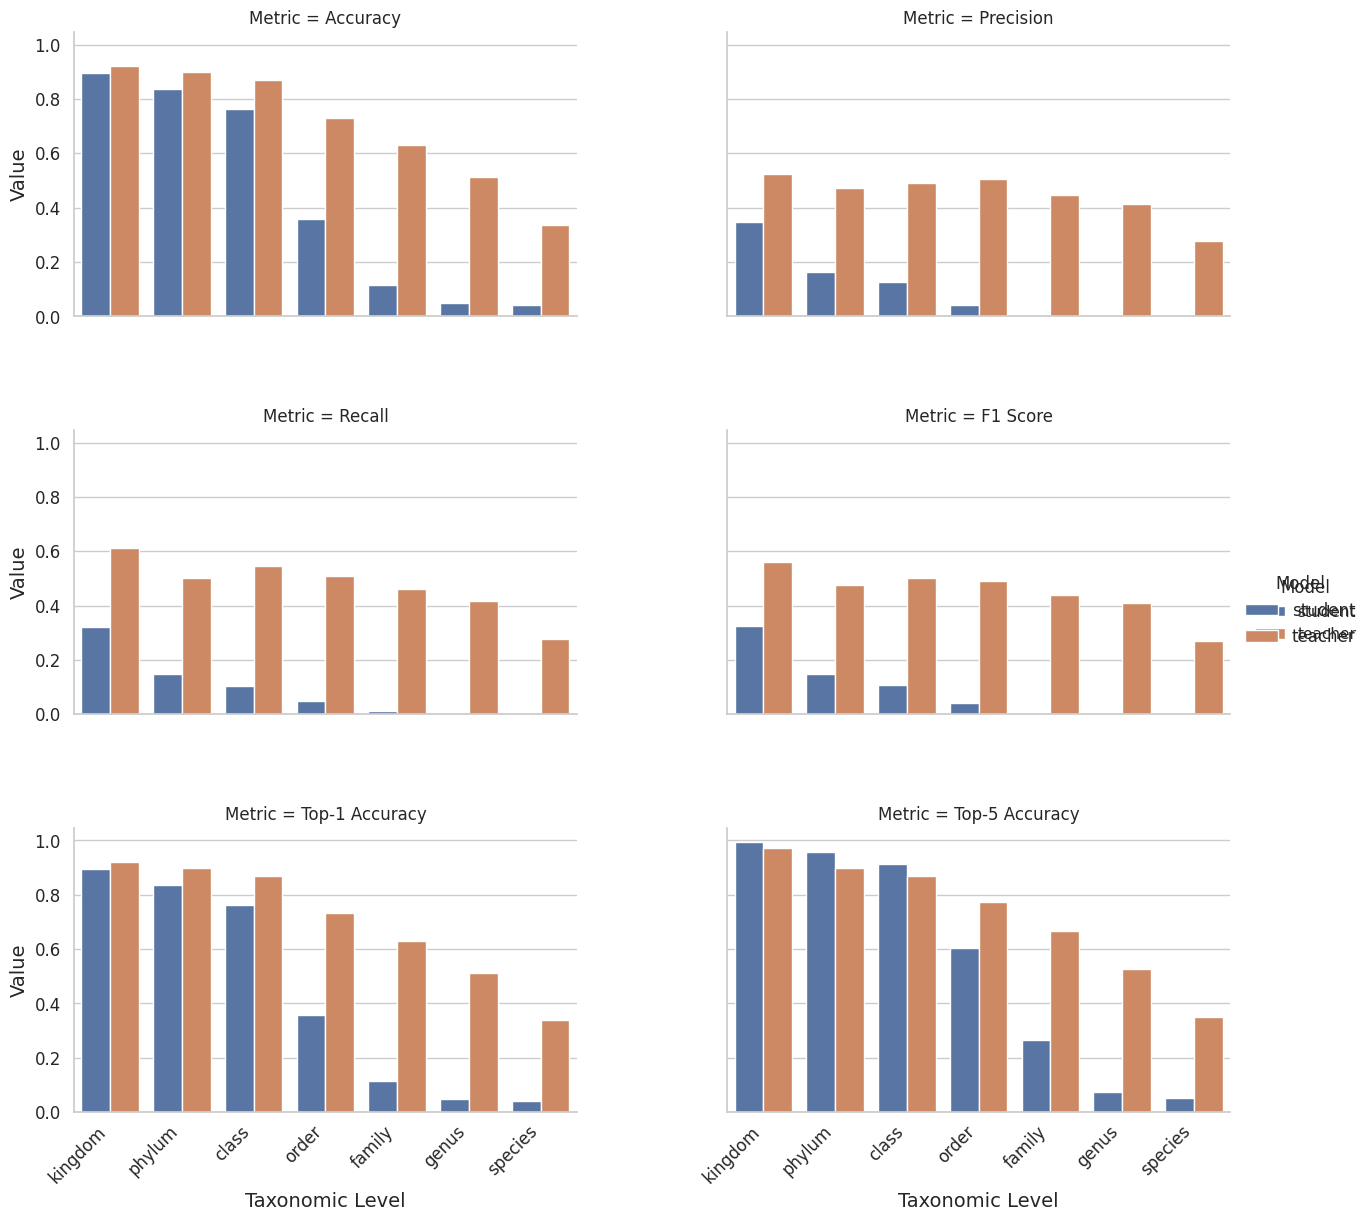

In [81]:
# Convert metrics to DataFrame
data = []
for model, levels in saved_metrics.items():
    for level, metrics in levels.items():
        for metric, value in metrics.items():
            data.append([model, level, metric, value])

df = pd.DataFrame(data, columns=["Model", "Taxonomic Level", "Metric", "Value"])

# Plotting
sns.set(style="whitegrid")
g = sns.catplot(
    x="Taxonomic Level", y="Value", hue="Model", col="Metric",
    data=df, kind="bar", height=5, aspect=1.2, col_wrap=2
)

# Explicitly set tick labels for each subplot
for ax in g.axes.flatten():
    ax.set_xticks(range(len(df["Taxonomic Level"].unique())))  # Explicitly set positions
    ax.set_xticklabels(
        df["Taxonomic Level"].unique(), rotation=45, ha="right", fontsize=12
    )
    ax.xaxis.label.set_visible(True)  # Ensure x-axis labels are visible
    ax.tick_params(axis='x', which='both', length=4, labelsize=12)  # Add tick marks and increase label size
    ax.tick_params(axis='y', labelsize=12)  # Increase y-axis label size
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)  # Increase y-axis title size
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # Increase x-axis title size

# Adjust spacing
g.fig.subplots_adjust(top=0.92, bottom=0.2, left=0.1, right=0.95, hspace=0.4, wspace=0.3)
g.add_legend(title="Model", fontsize=12, title_fontsize=14)
plt.show()

In [71]:
# RUN MODEL ON TEST DATASET

# Load the saved model
student_model = TaxonomyTinyViT(num_classes_per_level)
student_model.load_state_dict(torch.load(model_save_path))
student_model.to(device)
student_model.eval()

# Initialize metrics storage
metrics = {
    "accuracy": {},
    "precision": {},
    "recall": {},
    "f1_score": {},
    "top_1_accuracy": {},
    "top_5_accuracy": {}
}

# Iterate through the test dataset
with torch.no_grad():
    for batch_idx, (images, hard_labels, raw_images) in enumerate(tqdm(test_loader, desc="Evaluating Test Data")):
        images = images.to(device)

        # Forward pass
        logits = student_model(images)

        # Compute metrics for each taxonomy level
        for level in hard_labels.keys():
            # Get ground truth and predictions
            true_labels = hard_labels[level].to(device)
            pred_labels = torch.argmax(logits[level], dim=1)

            # Compute metrics
            metrics["accuracy"].setdefault(level, []).append(
                accuracy_score(true_labels.cpu(), pred_labels.cpu())
            )
            metrics["precision"].setdefault(level, []).append(
                precision_score(true_labels.cpu(), pred_labels.cpu(), average="macro", zero_division=0)
            )
            metrics["recall"].setdefault(level, []).append(
                recall_score(true_labels.cpu(), pred_labels.cpu(), average="macro", zero_division=0)
            )
            metrics["f1_score"].setdefault(level, []).append(
                f1_score(true_labels.cpu(), pred_labels.cpu(), average="macro", zero_division=0)
            )

            # Top-1 accuracy
            top_1_correct = (pred_labels == true_labels).sum().item()
            metrics["top_1_accuracy"].setdefault(level, []).append(top_1_correct / len(true_labels))

            # Top-5 accuracy
            top_k = torch.topk(logits[level], k=5, dim=1).indices
            top_5_correct = sum(true_labels[i] in top_k[i] for i in range(len(true_labels)))
            metrics["top_5_accuracy"].setdefault(level, []).append(top_5_correct / len(true_labels))

# Aggregate metrics across all batches
final_metrics = {metric: {} for metric in metrics.keys()}
for metric, levels in metrics.items():
    for level, values in levels.items():
        final_metrics[metric][level] = sum(values) / len(values)  # Average across batches

# Display results
print("\n=== Test Set Evaluation Results ===")
for level in final_metrics["accuracy"].keys():
    print(f"Level: {level}")
    print(f"  Accuracy: {final_metrics['accuracy'][level]:.4f}")
    print(f"  Precision: {final_metrics['precision'][level]:.4f}")
    print(f"  Recall: {final_metrics['recall'][level]:.4f}")
    print(f"  F1 Score: {final_metrics['f1_score'][level]:.4f}")
    print(f"  Top-1 Accuracy: {final_metrics['top_1_accuracy'][level]:.4f}")
    print(f"  Top-5 Accuracy: {final_metrics['top_5_accuracy'][level]:.4f}")

Evaluating Test Data: 100%|██████████| 69/69 [03:05<00:00,  2.69s/it]


=== Test Set Evaluation Results ===
Level: kingdom
  Accuracy: 0.8776
  Precision: 0.5893
  Recall: 0.6081
  F1 Score: 0.5931
  Top-1 Accuracy: 0.8776
  Top-5 Accuracy: 0.9964
Level: phylum
  Accuracy: 0.8107
  Precision: 0.5288
  Recall: 0.5542
  F1 Score: 0.5328
  Top-1 Accuracy: 0.8107
  Top-5 Accuracy: 0.9581
Level: class
  Accuracy: 0.7505
  Precision: 0.4367
  Recall: 0.4625
  F1 Score: 0.4383
  Top-1 Accuracy: 0.7505
  Top-5 Accuracy: 0.9163
Level: order
  Accuracy: 0.3391
  Precision: 0.1703
  Recall: 0.2179
  F1 Score: 0.1796
  Top-1 Accuracy: 0.3391
  Top-5 Accuracy: 0.5925
Level: family
  Accuracy: 0.1183
  Precision: 0.0412
  Recall: 0.0799
  F1 Score: 0.0487
  Top-1 Accuracy: 0.1183
  Top-5 Accuracy: 0.2686
Level: genus
  Accuracy: 0.0524
  Precision: 0.0063
  Recall: 0.0316
  F1 Score: 0.0080
  Top-1 Accuracy: 0.0524
  Top-5 Accuracy: 0.0813
Level: species
  Accuracy: 0.0417
  Precision: 0.0014
  Recall: 0.0224
  F1 Score: 0.0025
  Top-1 Accuracy: 0.0417
  Top-5 Accuracy

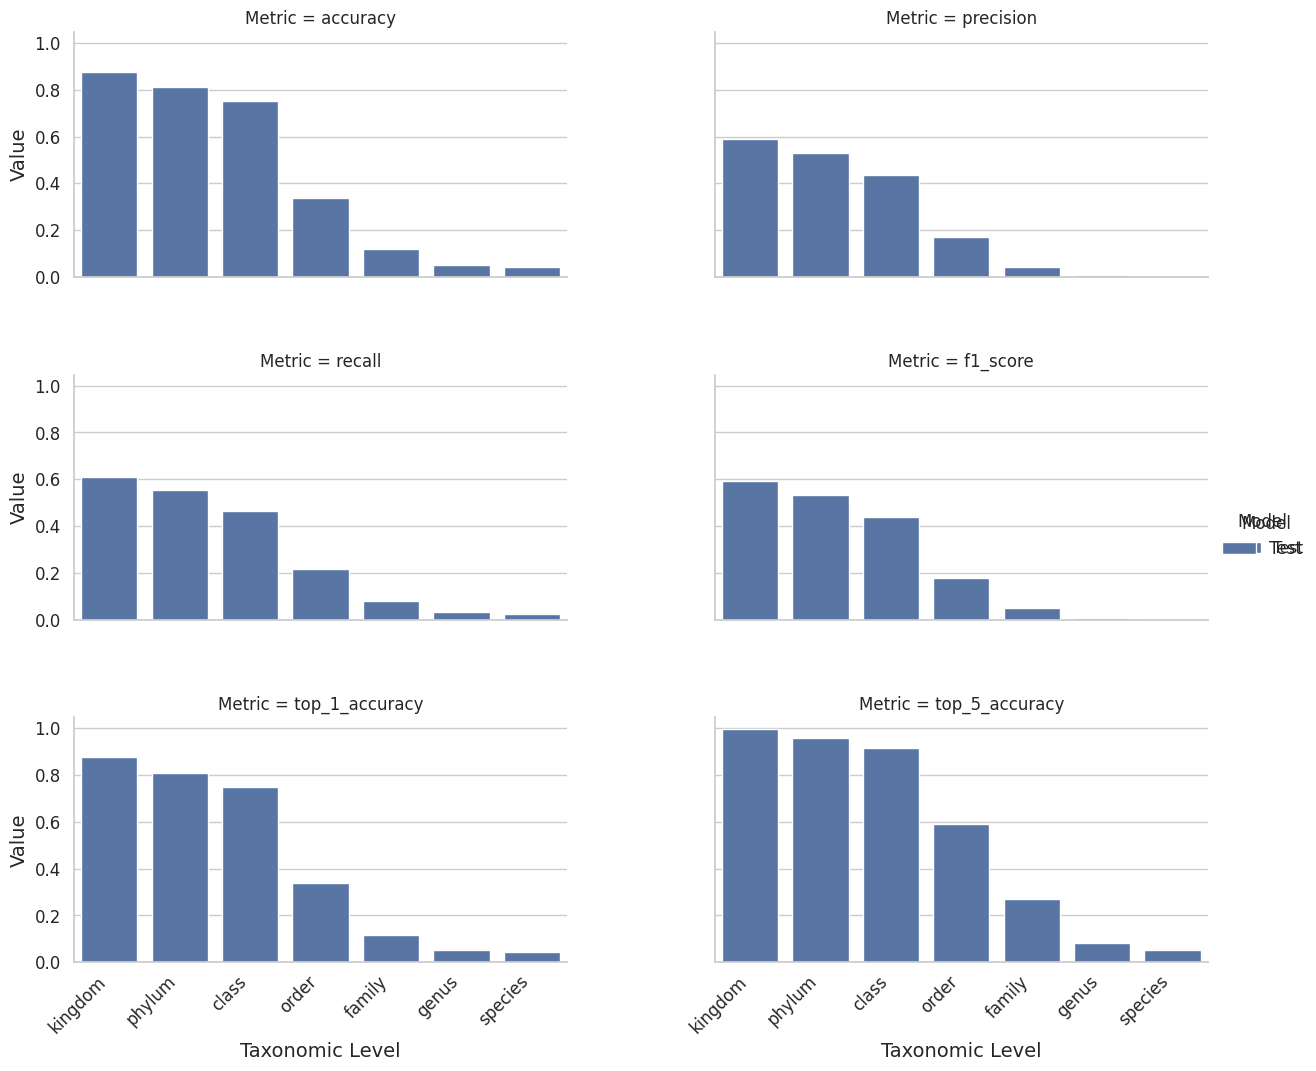

In [82]:
# Convert test metrics to DataFrame
data = []
for metric, levels in final_metrics.items():
    for level, value in levels.items():
        data.append(["Test", level, metric, value])  # Only one model, "Student"

df = pd.DataFrame(data, columns=["Model", "Taxonomic Level", "Metric", "Value"])

# Plotting
sns.set(style="whitegrid")
g = sns.catplot(
    x="Taxonomic Level", y="Value", hue="Model", col="Metric",
    data=df, kind="bar", height=5, aspect=1.2, col_wrap=2
)

# Explicitly set tick labels for each subplot
for ax in g.axes.flatten():
    ax.set_xticks(range(len(df["Taxonomic Level"].unique())))  # Explicitly set positions
    ax.set_xticklabels(
        df["Taxonomic Level"].unique(), rotation=45, ha="right", fontsize=12
    )
    ax.xaxis.label.set_visible(True)  # Ensure x-axis labels are visible
    ax.tick_params(axis='x', which='both', length=4, labelsize=12)  # Add tick marks and increase label size
    ax.tick_params(axis='y', labelsize=12)  # Increase y-axis label size
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)  # Increase y-axis title size
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # Increase x-axis title size

# Adjust spacing
g.fig.subplots_adjust(top=0.92, bottom=0.3, left=0.1, right=0.95, hspace=0.4, wspace=0.3)
g.add_legend(title="Model", fontsize=12, title_fontsize=14)
plt.show()

In [80]:
# Evaluate model size and performance metrics for mobile devices


model_save_path = "/content/drive/MyDrive/DL24/Project/student_model.pth"

# Model size
model_size = os.path.getsize(model_save_path) / (1024 ** 2)  # Convert to MB
print(f"Model size on disk: {model_size:.2f} MB")

# Number of parameters
num_params = sum(p.numel() for p in student_model.parameters())
print(f"Number of parameters: {num_params}")

# Create a dummy input to simulate a single forward pass
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Adjust input size as needed

# Perform FLOP analysis
flops = FlopCountAnalysis(student_model, dummy_input)
print(f"FLOPs: {flops.total() / 1e9:.2f} GFLOPs")

# Test on a single batch to simulate inference
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Adjust input size
student_model.eval()

# Warm-up (optional)
with torch.no_grad():
    for _ in range(10):
        _ = student_model(dummy_input)

# Measure inference time
n_runs = 100
start_time = time.time()
with torch.no_grad():
    for _ in range(n_runs):
        _ = student_model(dummy_input)
end_time = time.time()

avg_inference_time = (end_time - start_time) / n_runs
print(f"Average inference time: {avg_inference_time:.4f} seconds")

# Create a DataFrame to display the metrics
metrics = {
    "Metric": ["Model size (MB)", "Number of parameters", "FLOPs (GFLOPs)", "Average inference time (seconds)"],
    "Value": [f"{model_size:.2f}", f"{num_params}", f"{flops.total() / 1e9:.2f}", f"{avg_inference_time:.4f}"]
}

df = pd.DataFrame(metrics)
print(df)

# Optionally, display the DataFrame using a more visually appealing method if in a Jupyter notebook
try:
    from IPython.display import display
    display(df)
except ImportError:
    pass

Model size on disk: 34.71 MB
Number of parameters: 9082355


FLOPs: 0.44 GFLOPs
Average inference time: 0.0079 seconds
                             Metric    Value
0                   Model size (MB)    34.71
1              Number of parameters  9082355
2                    FLOPs (GFLOPs)     0.44
3  Average inference time (seconds)   0.0079


,Metric,Value
0,Model size (MB),34.71
1,Number of parameters,9082355
2,FLOPs (GFLOPs),0.44
3,Average inference time (seconds),0.0079
